In [9]:
import torch
from datasets import IndexedDataset, WeightedDataset
from torch.utils.data import DataLoader, DistributedSampler

from utils import get_args
from architectures import load_architecture

from samplers import DistributedCustomSampler
from losses import trades_loss
from tqdm.notebook import tqdm
from architectures import load_architecture, add_lora, set_lora_gradients #load_statedict

import torch.nn as nn
from timm.models import create_model

args = get_args()
args.arch = 'convnext'
args.dataset = 'CIFAR10'
args.selection_method = 'random'
args.aug = 'aug'
args.pre_trained = ''
args.loss_function = 'TRADES_v2'

args.iterations = 5
args.pruning_ratio = 0.3
args.delta = 1
args.batch_size = 24
args.pruning_strategy = 'random'
args.batch_strategy = 'random'
args.sample_size= 128
args.init_lr = 0.0001

# Example Usage


model = load_architecture(args)


# state_dict = torch.load('./state_dicts/weights_convnext_base.pt')
# model.load_state_dict(state_dict)



# model, target_layers = load_architecture(args)

# add_lora(args, model, target_layers)

# set_lora_gradients(args, model, target_layers)
# model.to('cuda')

# statedict = load_statedict(args)
# model.load_state_dict(statedict)
# add_lora(target_layers, model)

# train_dataset = WeightedDataset(args, train=True, prune_ratio = args.pruning_ratio,  )

# train_sampler = DistributedCustomSampler(args, train_dataset, num_replicas=2, rank=0, drop_last=True)

# trainloader = DataLoader(train_dataset, batch_size=None, sampler = train_sampler,) 

./data


In [5]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [43]:
model.state_dict().keys()

odict_keys(['stem.0.weight', 'stem.0.bias', 'stem.1.weight', 'stem.1.bias', 'stages.0.blocks.0.gamma', 'stages.0.blocks.0.conv_dw.weight', 'stages.0.blocks.0.conv_dw.bias', 'stages.0.blocks.0.norm.weight', 'stages.0.blocks.0.norm.bias', 'stages.0.blocks.0.mlp.fc1.weight', 'stages.0.blocks.0.mlp.fc1.bias', 'stages.0.blocks.0.mlp.fc2.weight', 'stages.0.blocks.0.mlp.fc2.bias', 'stages.0.blocks.1.gamma', 'stages.0.blocks.1.conv_dw.weight', 'stages.0.blocks.1.conv_dw.bias', 'stages.0.blocks.1.norm.weight', 'stages.0.blocks.1.norm.bias', 'stages.0.blocks.1.mlp.fc1.weight', 'stages.0.blocks.1.mlp.fc1.bias', 'stages.0.blocks.1.mlp.fc2.weight', 'stages.0.blocks.1.mlp.fc2.bias', 'stages.0.blocks.2.gamma', 'stages.0.blocks.2.conv_dw.weight', 'stages.0.blocks.2.conv_dw.bias', 'stages.0.blocks.2.norm.weight', 'stages.0.blocks.2.norm.bias', 'stages.0.blocks.2.mlp.fc1.weight', 'stages.0.blocks.2.mlp.fc1.bias', 'stages.0.blocks.2.mlp.fc2.weight', 'stages.0.blocks.2.mlp.fc2.bias', 'stages.1.downsample.

In [30]:
state_dict

OrderedDict([('module.base_model.normalize.mean',
              tensor([[[[0.4850]],
              
                       [[0.4560]],
              
                       [[0.4060]]]], device='cuda:0')),
             ('module.base_model.normalize.std',
              tensor([[[[0.2290]],
              
                       [[0.2240]],
              
                       [[0.2250]]]], device='cuda:0')),
             ('module.base_model.model.stem.0.weight',
              tensor([[[[-4.5237e-03, -1.0337e-02, -3.8783e-03,  1.3135e-05],
                        [ 1.6772e-03,  8.0211e-03, -5.9059e-03,  2.5079e-03],
                        [-1.8650e-03,  1.5883e-03,  6.6207e-04, -6.0478e-03],
                        [ 3.1581e-05, -1.2085e-02,  1.9935e-05, -2.8413e-03]],
              
                       [[ 4.2303e-05,  1.9674e-02,  2.7803e-05,  3.2552e-03],
                        [ 8.0408e-03,  4.6628e-05,  1.9701e-02,  2.0645e-05],
                        [ 2.9409e-05,  1.1311e-02,

In [21]:
model.patch_embed.proj.weight

Parameter containing:
tensor([[[[ 3.8981e-01,  4.9707e-01, -3.1674e-01, -1.7070e-01],
          [ 2.0831e-01, -4.3934e-01, -2.0482e-01,  6.0037e-01],
          [-2.9027e-01, -4.4327e-01, -2.8832e-01,  1.4148e-01],
          [-4.5794e-01,  5.6164e-01, -1.3939e-02,  1.1305e-01]],

         [[-1.8046e-01, -4.1214e-01, -5.7452e-01, -2.6441e-02],
          [-7.1759e-02,  1.1530e+00,  7.0930e-01, -4.2452e-01],
          [ 2.8364e-01,  6.0130e-01, -3.5327e-01, -6.3746e-02],
          [-5.5725e-01,  1.3774e-01, -2.1699e-01, -5.5242e-05]],

         [[-2.1578e-01, -2.7020e-01,  9.6664e-02,  3.7320e-01],
          [-1.4221e-01, -2.4538e-01,  1.7353e-01, -4.7863e-01],
          [ 2.9003e-01, -6.0898e-01,  3.9788e-01, -2.1511e-01],
          [ 4.0702e-02,  3.0789e-01,  7.2231e-02,  3.8878e-01]]],


        [[[-2.4355e-01,  3.1625e-01, -1.1850e-01,  7.1742e-02],
          [ 9.5127e-02,  5.6052e-01,  8.4673e-01, -1.4109e-01],
          [-4.5541e-02, -1.4487e+00,  8.2882e-01, -5.4414e-01],
          

In [19]:
model.patch_embed.proj.weight

Parameter containing:
tensor([[[[ 3.0717e-02,  1.0721e-02,  1.1499e-02,  ...,  2.0554e-02,
            6.2025e-03,  1.3876e-02],
          [ 1.7247e-02,  3.3034e-02,  3.7861e-02,  ..., -4.5948e-03,
           -1.8755e-02, -9.9077e-03],
          [ 7.9711e-03,  3.1870e-02,  6.9038e-02,  ..., -2.9888e-02,
           -1.3319e-02,  6.3127e-03],
          ...,
          [-1.8883e-02, -2.3760e-02, -2.3810e-02,  ...,  1.6334e-02,
           -2.2924e-03, -2.0550e-02],
          [ 2.3224e-03, -1.5491e-02, -2.5733e-02,  ...,  1.7991e-02,
            6.8163e-03, -3.8096e-03],
          [-8.7895e-03, -3.0415e-02, -3.4190e-02,  ...,  2.6982e-02,
            1.2295e-02,  7.0895e-03]],

         [[ 7.1748e-03, -8.8019e-03, -1.5167e-02,  ...,  3.7163e-02,
            2.3875e-02,  2.4656e-02],
          [ 7.5335e-03,  4.5109e-03,  7.2069e-03,  ...,  4.2437e-03,
           -7.4785e-03,  6.2875e-03],
          [-1.1697e-02,  6.0440e-03,  2.9853e-02,  ..., -2.9085e-02,
           -1.1919e-02,  1.3047e-02]

In [24]:
from losses import get_loss, get_eval_loss
import numpy as np

import numpy as np

rank = 'cuda'

optimizer = torch.optim.SGD( model.parameters(),lr=args.init_lr, weight_decay=args.weight_decay, momentum=args.momentum, nesterov=True, )

for iteration in range(args.iterations):

    model.eval()
    train_sampler.set_epoch(iteration)

    for batch_id, batch in tqdm(enumerate( trainloader ) ):

        optimizer.zero_grad()

        data, target, idxs = batch

        # print(idxs)

        data, target = data.to(rank), target.to(rank) 
        print(data.shape)
        
        pred = model(data)

        print(pred.shape)
        # loss_values, clean_values, robust_values, logits_nat, logits_adv = get_loss(args, model, data, target, optimizer)
        # print(logits_adv.shape)
        # print(logits_nat.shape)
        # assert torch.isfinite(loss_values).all(), "Loss contains NaNs!"
        # assert torch.isfinite(logits_nat).all(), "Logits_nat contains NaNs!"
        # assert torch.isfinite(logits_adv).all(), "Logits_adv contains NaNs!"

        # train_dataset.update_scores(iteration, idxs,loss_values)
        # train_dataset.update_scores(rank, idxs, clean_values, robust_values, loss_values, logits_nat, logits_adv)
        
        # loss = train_dataset.compute_loss(idxs, loss_values)

        # loss.backward()
        # optimizer.step()

    # if args.pruning_strategy in [ 'decay_based', 'decay_based_v2', 'decay_based_v3']:
    #     print('start decay')
    #     indices = train_sampler.process_indices
    #     train_dataset.decay_model.reset_counters()
    #     results = torch.tensor([ train_dataset.decay_model.fit_predict( train_dataset.global_scores2[idx] ) for idx in indices ])
    #     results = results.to(dtype=torch.float32)
    #     train_dataset.alphas[indices] = results[:,0]
    #     train_dataset.betas[indices] = results[:,1]
    #     train_dataset.cetas[indices] = results[:,2]
    #     train_dataset.pred_decay[indices] = results[:,4]
    
    # print('betas',max(train_dataset.betas), min(train_dataset.betas) )
    # print('pred decay', max(train_dataset.pred_decay), min(train_dataset.pred_decay) )
    # print(train_dataset.alphas)

    # print(loss)

pruning
remove tail
process


0it [00:00, ?it/s]

torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 32, 32])
torch.Size([24, 10])
torch.Size([24, 3, 3

KeyboardInterrupt: 

In [6]:
from architectures.resnet_imagenet import ResNet_imagenet, Bottleneck_imagenet
model = ResNet_imagenet(Bottleneck_imagenet, [3, 4, 6, 3], )
num_features = model.fc.in_features
print(num_features)
model.fc = nn.Linear(num_features, 10)

2048


torch.Size([5, 60000])


  0%|          | 0/100 [00:00<?, ?it/s]

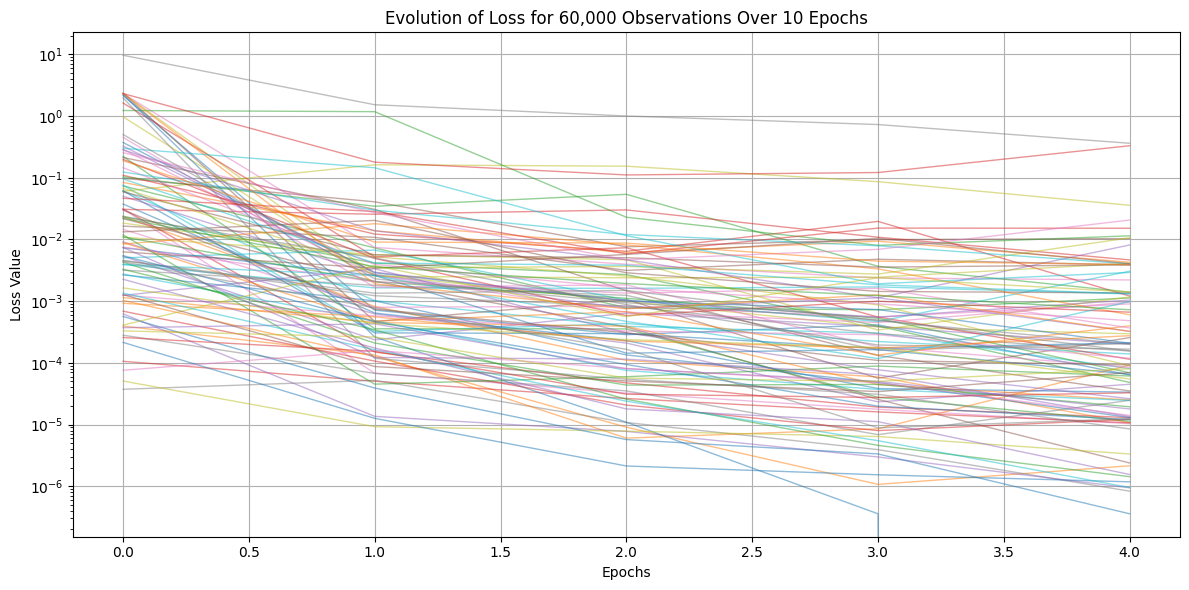

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a sample tensor with dimensions (10, 60000)
# Each of the 10 rows represents an epoch, and each column represents a loss value for one of the 60,000 observations.
np.random.seed(0)  # For reproducibility
tensor = train_dataset.global_scores2 #np.random.rand(10, 60000)  # Simulating loss values

# Sampling 1000 observations from the 60,000
print(tensor.shape)
sample_indices = np.random.choice(tensor.shape[1], size=100, replace=False)

sampled_tensor = tensor[:, sample_indices]

# Plotting the evolution of the loss for the 60,000 observations over 10 epochs
plt.figure(figsize=(12, 6))

# Plotting each observation's loss over the 10 epochs
for i in tqdm(range(sampled_tensor.shape[1])):
    plt.plot(range(args.iterations), sampled_tensor[:, i], alpha=0.5, linewidth=1)  # Plotting with low opacity and thin lines for clarity

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.yscale('log')  # Setting y-axis to log scale

plt.title('Evolution of Loss for 60,000 Observations Over 10 Epochs')
plt.grid(True)
plt.tight_layout()

plt.show()


In [3]:
observations_losses = train_dataset.global_scores2.T.numpy()

In [ ]:


import numpy as np

def obtain_latent_dataset(model, dataset, batch_size=32):

    # Assuming the dataset is a list or similar iterable with a known length
    num_samples = len(dataset)

    # Assume the dimensionality of the latent representation can be determined from one sample
    image,label, idx = dataset[0]
    image = torch.Tensor(image).to('cuda').unsqueeze(0)
    print(image.shape)
    first_latent_rep = model.get_latent_representation(image)
    latent_dim = first_latent_rep.shape[1]
    print(first_latent_rep.shape)
        
    # Preallocate the array for the latent representations
    latent_dataset = torch.zeros((num_samples, latent_dim))


    for i in tqdm( range(0, num_samples, batch_size) ):
        # Get the current batch of data
        batch_indices = list(range(i, min(i + batch_size, num_samples)))
        images,labels,idxs = dataset[batch_indices]
        images = images.to('cuda')
            
        # Process the batch to get latent representations
        batch_latent_reps = model.get_latent_representation(images) 
            
        # Store the results in the preallocated array
        latent_dataset[i:i + batch_size] = batch_latent_reps.detach().cpu()

    return latent_dataset

features =  obtain_latent_dataset(model,train_dataset,64)
train_dataset.define_latent_features(features)

